# Image Colorization using Autoencoders

## Introduction 
An autoencoder is a form of neural network used for feature learning and dimensionality reduction. It
consists of two components: a decoder that maps the lower-dimensional representation back to the original
input space from the encoder's lower-dimensional representation of the input data. Autoencoders are trained
by feeding them input data and trying to reconstruct the original input from the lower-dimensional
representation. This forces both the encoder and the decoder to learn how to reconstruct the original input
from the compressed representation of the input data. It can be trained using unsupervised, semi-supervised,
or supervised learning methods.

Image colorization is an interesting problem because it involves using machine learning to add color to
grayscale images in a way that accurately represents the original image. Autoencoders are well-suited for
this task because they can learn the structure of an image, which allows them to generate new data that is
consistent with that structure. Additionally, solving this problem has the potential to provide benefits in
various applications, such as improving the visual quality of old black and white photos or making it easier
to analyze satellite images. It can be used to colorize medical scans and images, making them simpler to
comprehend and study in the field of medicine. It can be used to colorize old records and artifacts in the
study of history, giving a more realistic depiction of how they appeared at the time of creation.

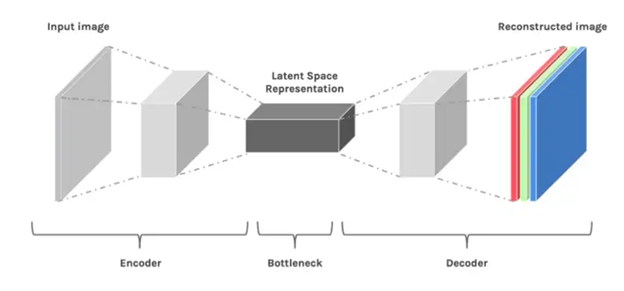

### Importing necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import CSVLogger
import pandas


from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

## Dataset and Preprocessing
We used a Kaggle dataset which contains the grayscale and their corresponding color images. We divided them into train, validation, and test data - 5000, 500, 500 pictures respectively. We use cv2 library to convert color images to red, green, and blue channels on a scale of 0 to 255 and making them a size of 160x160x3. and grayscale of size 160x160x1 matrices.


In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 84%|████████▍ | 6000/7129 [01:16<00:14, 78.37it/s]


In [3]:
# defining function to plot images pair
def plot_images(grayscale,color):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Grayscale Image ', color = 'black', fontsize = 16)
    plt.imshow(grayscale)
    plt.subplot(1,3,2)
    plt.title('Color Image', color = 'green', fontsize = 16)
    plt.imshow(color)
    
   
    plt.show()

### Instance of Dataset

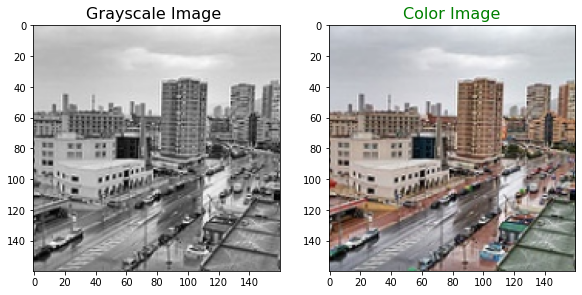

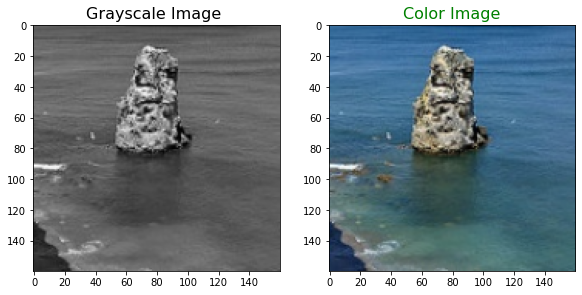

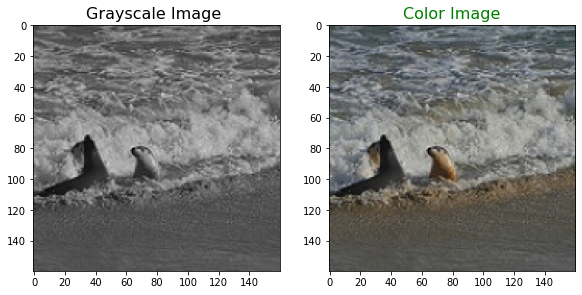

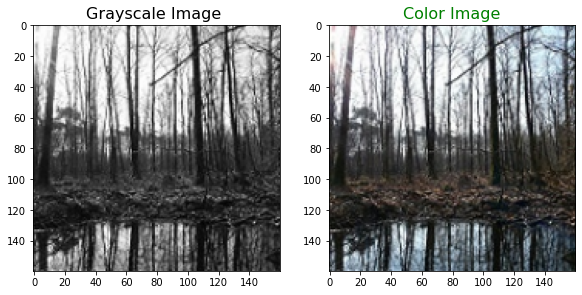

In [4]:
for i in range(11,15):
     plot_images(gray_img[i],color_img[i])

In [5]:
train_gray_image = gray_img[:5000]
train_color_image = color_img[:5000]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]

valid_gray_image = gray_img[5000:5500]
valid_color_image = color_img[5000:5500]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


valid_gray_image = np.reshape(valid_gray_image,(len(valid_gray_image),SIZE,SIZE,3))
valid_color_image = np.reshape(valid_color_image, (len(valid_color_image),SIZE,SIZE,3))
print('Valid color image shape',valid_color_image.shape)

test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5000, 160, 160, 3)
Valid color image shape (500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


## Methodology
We used convolutional autoencoders to perform colorizing grayscale images. We used an architecture
inspired from U-Net which is famous for biomedical image segmentation and is designed to perform
semantic segmentation. Below is the U-Net architecture.

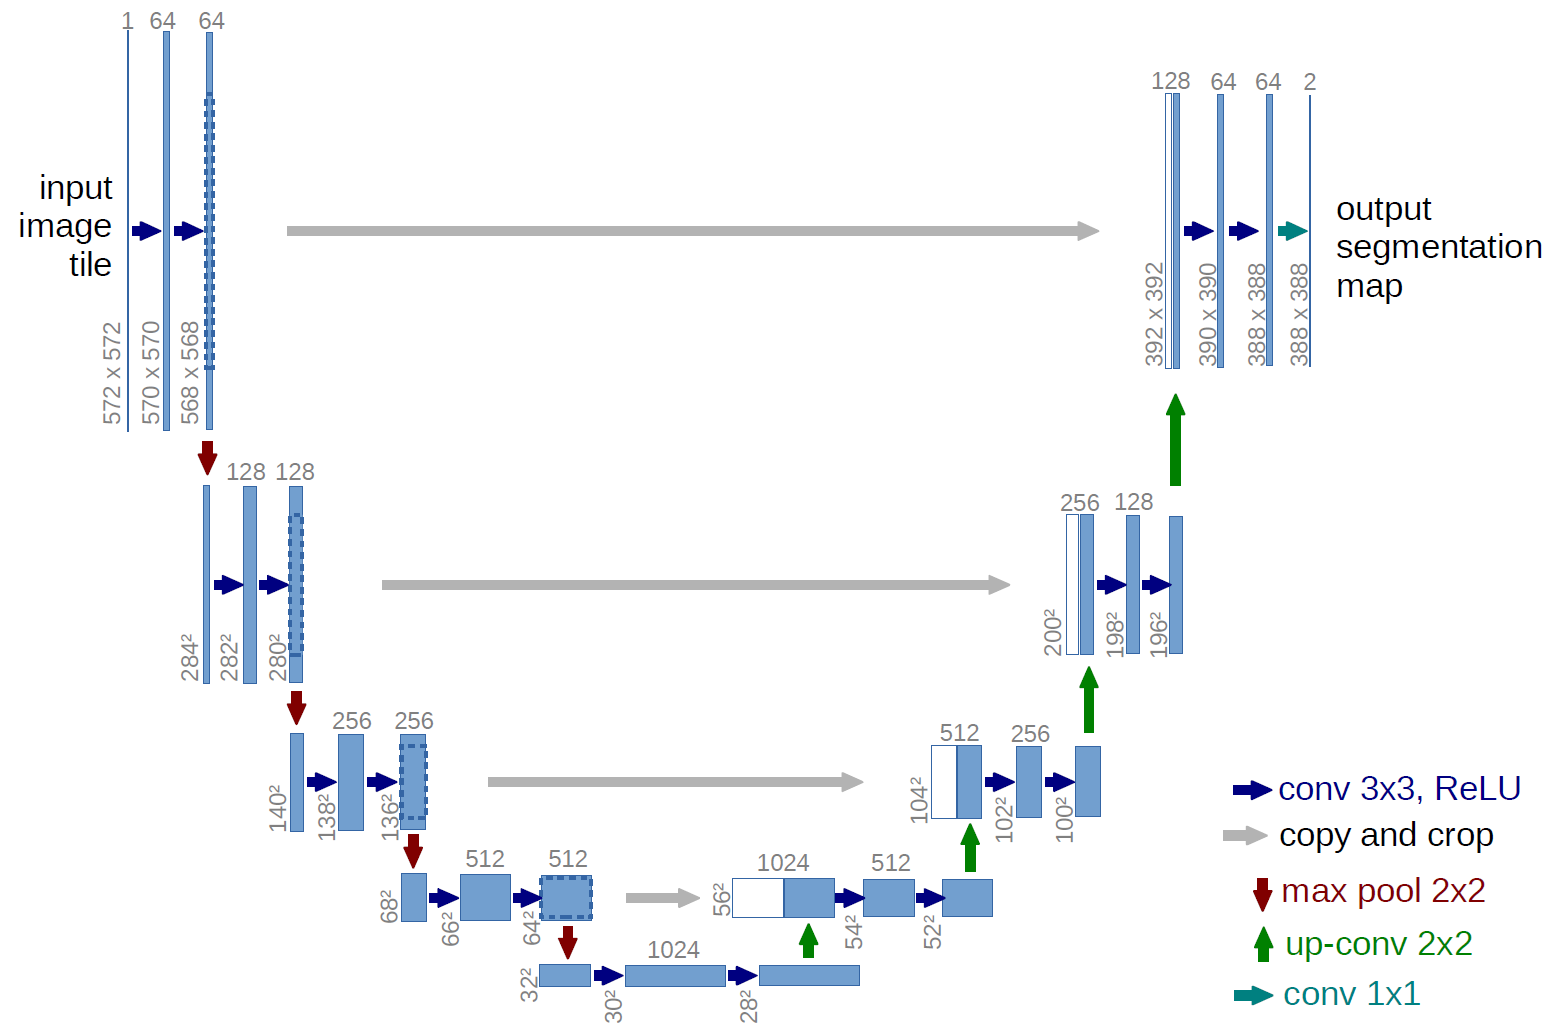

As biomedical problems need to not only classify but also locate the abnormality, U-Net achieves this by
implementing classification on every pixel of the image and distinguish boundaries, so that the output and
input share the same dimensions.

U-Net has an architecture of symmetric U-shape and has two main parts, the left side performs
contraction(encoding) using convolutional layers and the right side performs expansion(decoding) using
transpose convolutional layers. The images are downscaled during contraction and upscaled during
expansion. To avoid feature loss in the process, each encoder is linked to corresponding decoder using
concatenate layer. Concatenation of feature maps give localization information which makes the semantic
segmentation possible.

In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [7]:
def model():
    inputs = layers.Input(shape= [160,160,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

Our model has two blocks. The first layer is an input layer which takes the image size 160x160x1
(grayscale) and is followed by 5 Conv2D layers with strides 2, padding set as same which ensures output
and input image have same dimensions and increasing filter size which is shown above. We applied Batch
Normalization on 3rd, 4th and 5th Conv2D layers. During this process, each hidden layer’s output is
normalized using Batch Norm. We have bottleneck at 5th Conv2D layer which has a size of 10x10x1024.

The second block has 5 Conv2D Transpose layers with strides 2, padding set as same and decreasing filter
size. We added dropout layer which gets initialized if dropout gets defined. Each Conv2D Transpose layer
is followed by a concatenate layer which connects a Conv2D and a corresponding Conv2D Transpose layer
which allows to avoid feature loss. After the 5th Conv2D Transpose layer is concatenated to input layer, an
output layer performs Conv2D and brings the output size of 160x160x3. This last layer has strides = 1 and
filter size 3 to bring the RGB channels. All the layers are given a kernel size of (3,3) except the output layer
with (2,2)

In [8]:
model = model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  296192      sequential_1[0][0]               
_______________________________________________________________________________________

## Experimental Setup
### Activation function:
All the layers use LeakyReLU activation function. To overcome any possible vanishing gradient problem,
which happens when output is negative resulting in 0 when derivative is calculated.

### Optimizer and Learning rate:
With careful research and experimentation, we chose Adam optimizer and 0.001 learning rate. Adam
optimizer is said to have advantages of both RMSProp and AdaGrad and achieves good results faster than
other optimizers. We have seen that 0.001 learning rate yielded better results.

### Loss Function:
The loss function used is ‘Mean Absolute Error’ and accuracy metric. Although Mean Absolute error is a
popular solution for our problem it might face issues as colorizing is a multimodal problem, there are
various possible color versions which are acceptable for each pixel. This can lead to modelstrying to choose
colors with low vibrance to avoid high mean absolute error penalty leading to desaturated colorizations.

### Batch size, Epochs:
When training we used a batch size of 50 and experimented on several numbers of epochs. We finalized
having 100 epochs as the loss already reached a plateau for epochs more than 100. We added an
EarlyStopping callback, monitoring loss to avoid overfitting the model. Lastly, we used verbose of 0 and
validation data of color and grayscale images which was produced when splitting the dataset to monitor
progress and loss. We used Google Colab to run the code and used GPU for faster training and evaluating.

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

csv_logger = CSVLogger('modellogs.csv',separator=",", append=False)
history = model.fit(train_g, train_c, epochs = 200,batch_size = 50,verbose = 0,validation_data=(valid_gray_image, valid_color_image))
                   




## Results
When fitting model history.history modules stored the training and validation accuracies and losses. To
evaluate the autoencoder’s performance we plot training and validation losses over epochs and training and
validation accuracy over epochs

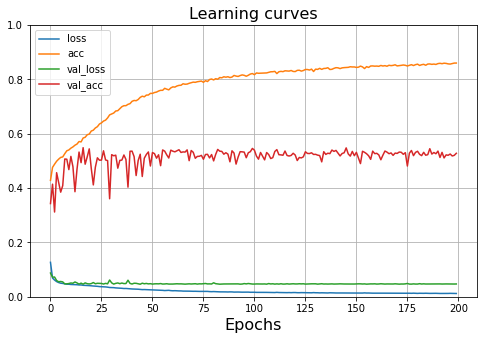

In [11]:
pandas.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs",fontsize=16)
plt.title("Learning curves",fontsize=16)
plt.show()

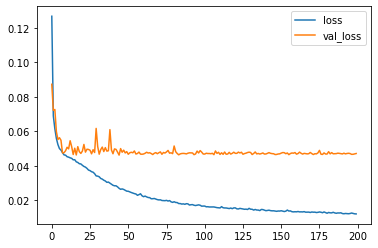

In [12]:
ax = plt.subplot(label= True)
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend(["loss", "val_loss"])

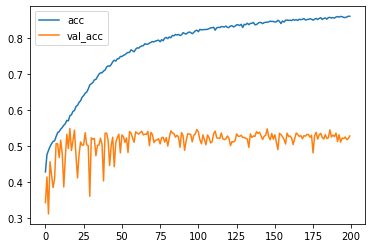

In [13]:
ax = plt.subplot(label= True)
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend(["acc", "val_acc"])

For the accuracy plot we see that training accuracy kept increasing and almost reached plateau whereas
validation accuracy has a lot of fluctuations and reached plateau way before training accuracy. We achieved
a lower validation accuracy but received good training accuracy.

For the loss plot we see training loss kept decreasing and almost reached plateau whereas validation loss
reached plateau before training loss. We see a substantial decrease in training loss than the validation loss.
The gap between training and validation lines can be explained by validation data not being a proper
representation of the entire dataset

In [14]:

model.evaluate(test_gray_image,test_color_image)


16/16 [==============================] - 1s 77ms/step - loss: 0.0479 - acc: 0.5446


[0.04786553233861923, 0.5446251034736633]

When evaluating the model using test dataset, we achieved an accuracy of 54% and loss of 48%. Accuracy
does not seem like a good measure to evaluate performance of autoencoders are there are various acceptable
colors for each pixel. So, checking the model’s performance by seeing the predicted results is a better way
of evaluation. After evaluation function we plotted color image, respective grayscale image and the
predicted color image from grayscale image.

## Plotting results

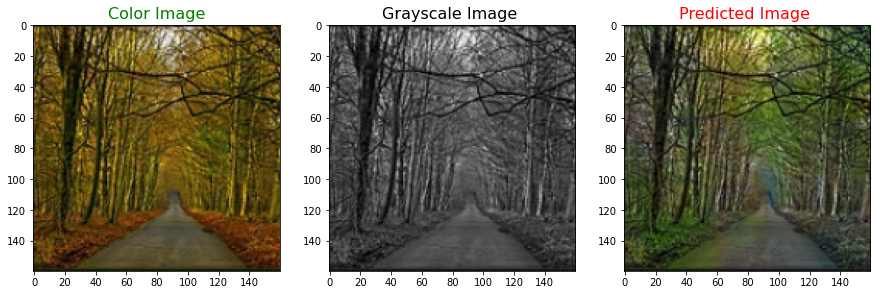

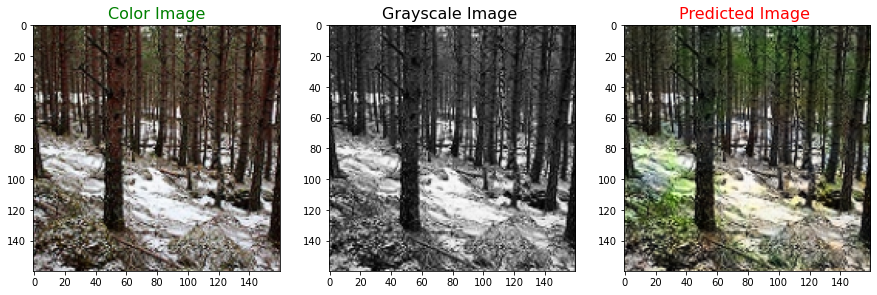

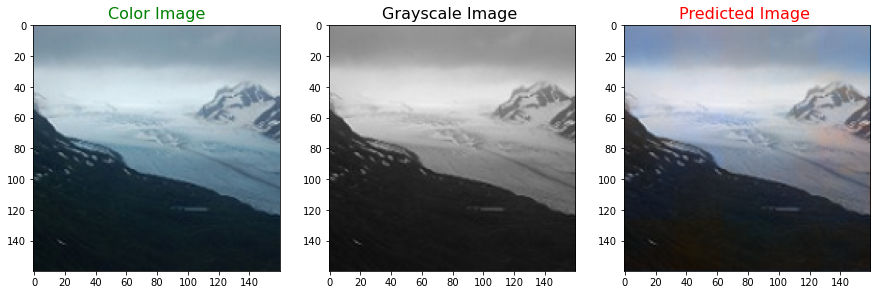

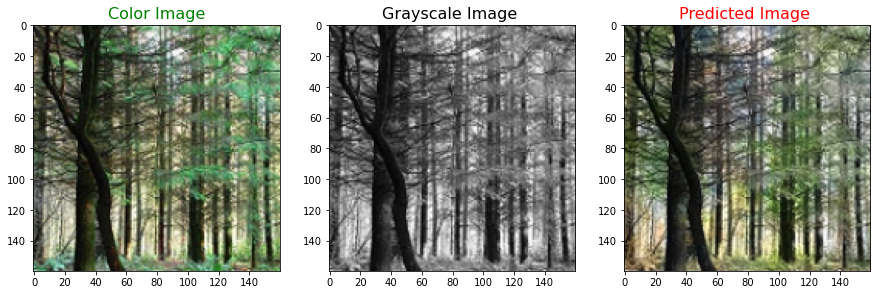

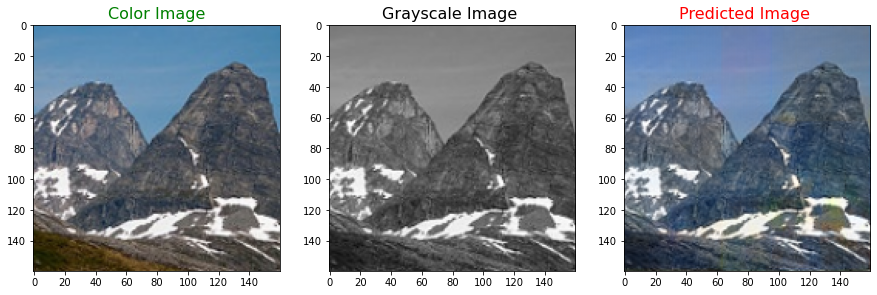

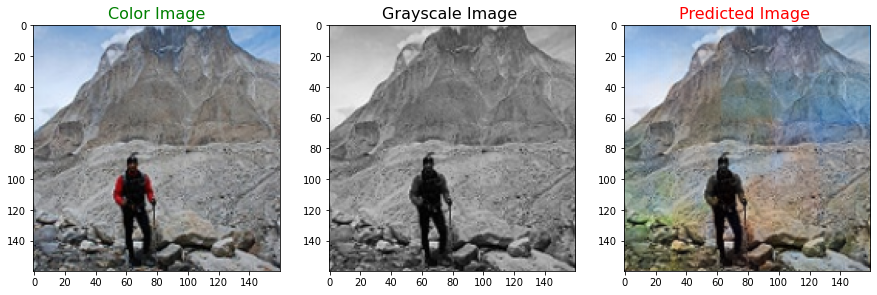

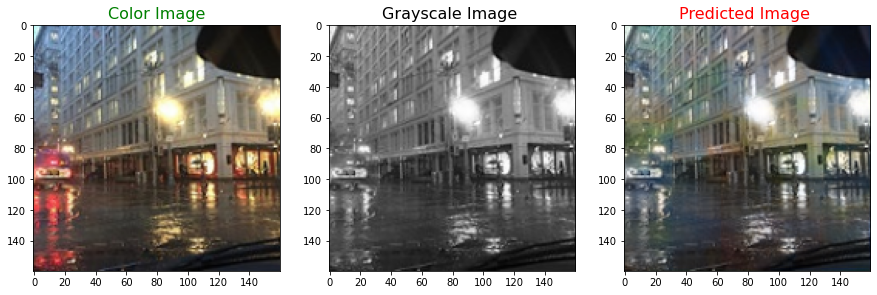

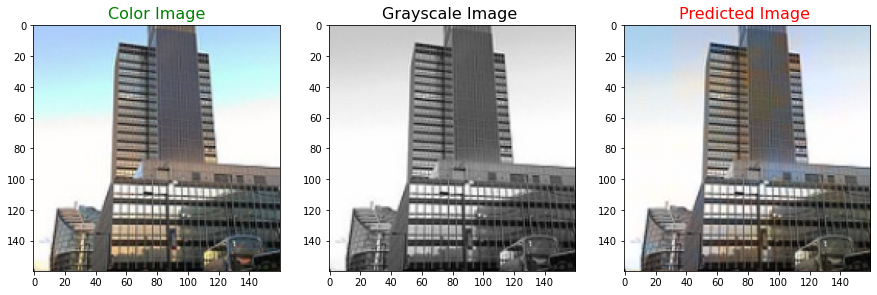

In [15]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 16)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 16)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 16)
    plt.imshow(predicted)
   
    plt.show()

for i in range(65,73):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 

## Conclusion
We have successfully created a convolutional autoencoder to colorize grayscale images. We converted
color images to RGB color space before training the model. We achieved a good prediction, and we plotted
losses and accuracies to evaluate the model performance.

The fluctuations and gap between training and validations lines in plots could be because of uneven
representation between validation and train sets. We didn’t receive low saturated output images, so Mean
Absolute error did a good job. The model also did a great job in capturing backgrounds as well as
foregrounds. The model also delivered output images in good resolution. The model did a good job in
sematic segmentation but struggled a little in deciding which color to use.


## References
1. https://towardsdatascience.com/image-colorization-using-convolutional-autoencodersfdabc1cb1dbe
2. https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset
3. https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
4. https://towardsdatascience.com/image-colorization-using-convolutional-autoencodersfdabc1cb1dbe
5. https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
6. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-modelperformance/
7. https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neuralnetworks/